In [2]:
from sklearn.utils.estimator_checks import check_estimator
from skbayes.rvm_ard_models import RVR,RVC
check_estimator(RVC)
check_estimator(RVR)
print "All test are passed ..."


All test are passed ...


In [45]:
from skbayes.rvm_ard_models import RVR
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from class_photoz import ml_quasar_sample as qs

# --------------------------------------------------------------------------
# Preparing the feature matrix
# --------------------------------------------------------------------------
df_train = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat.hdf5','data')
# df_train = pd.read_hdf('../class_photoz/data/brightqsos_sim_2k.hdf5','data')

passband_names = [\
        'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z', \
        # 'TMASS_j','TMASS_h','TMASS_k', \
        'WISE_w1','WISE_w2', \
        # 'WISE_w3' \
        ]

# for name in passband_names:
#     df_train.rename(columns={'obsFlux_'+name:name},inplace=True)
#     df_train.rename(columns={'obsFluxErr_'+name:'sigma_'+name},inplace=True)

df_train.replace(np.inf, np.nan,inplace=True)
df_train.query('10 > Z_VI > 0.0 and SDSS_mag_i < 19.5',inplace=True)
# df_train.query('obsMag_SDSS_i < 19.0',inplace=True)
df_train,features = qs.prepare_flux_ratio_catalog(df_train,passband_names)

# df_train = df_train.sample(frac=0.5)

# --------------------------------------------------------------------------
# Random Forest Regression Grid Search
# --------------------------------------------------------------------------

#features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']
features = ['ug','gr','ri','iz','zw1','w1w2']
# features = ['SDSS_i','WISE_w1','TMASS_j','ug','gr','ri','iz','zj','jh', 'hk', 'kw1', 'w1w2']
label = 'z'
rand_state = 1

print df_train.shape


(52944, 358)


In [49]:
from sklearn.cross_validation import train_test_split
from class_photoz import ml_sets as sets
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error


df_train = df_train.sample(frac=0.5)

# Building test and training sample
X,y = sets.build_matrices(df_train, features, label)

# Standardizing the data
X = preprocessing.robust_scale(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=rand_state)

print df_train.shape

# Relevance Vector Regression
rvm = RVR(gamma = 1,kernel = 'rbf')

rvm.fit(X_train,y_train)

y_pred,var     = rvm.predict_dist(X_test)
rvm_err   = mean_squared_error(y_pred,y_test)
rvs       = np.sum(rvm.active_)
print "RVM error on test set is {0}, number of relevant vectors is {1}".format(rvm_err, rvs)



(14824, 358)
RVM error on test set is 0.118542647095, number of relevant vectors is 299


Standard deviation: 
0.344232641889
R 0.3 :  0.872512647555
R 0.2 :  0.76155143339
R 0.1 :  0.489376053963
Redshift normalized standard devation: 
0.140394296735
Photometric Redshift evaluation
Total number of test objects :  2965
Delta z < 0.3 :  0.964249578415
Delta z < 0.2 :  0.93760539629
Delta z < 0.1 :  0.827993254637


<module 'matplotlib.pyplot' from '/home/jtschindler/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

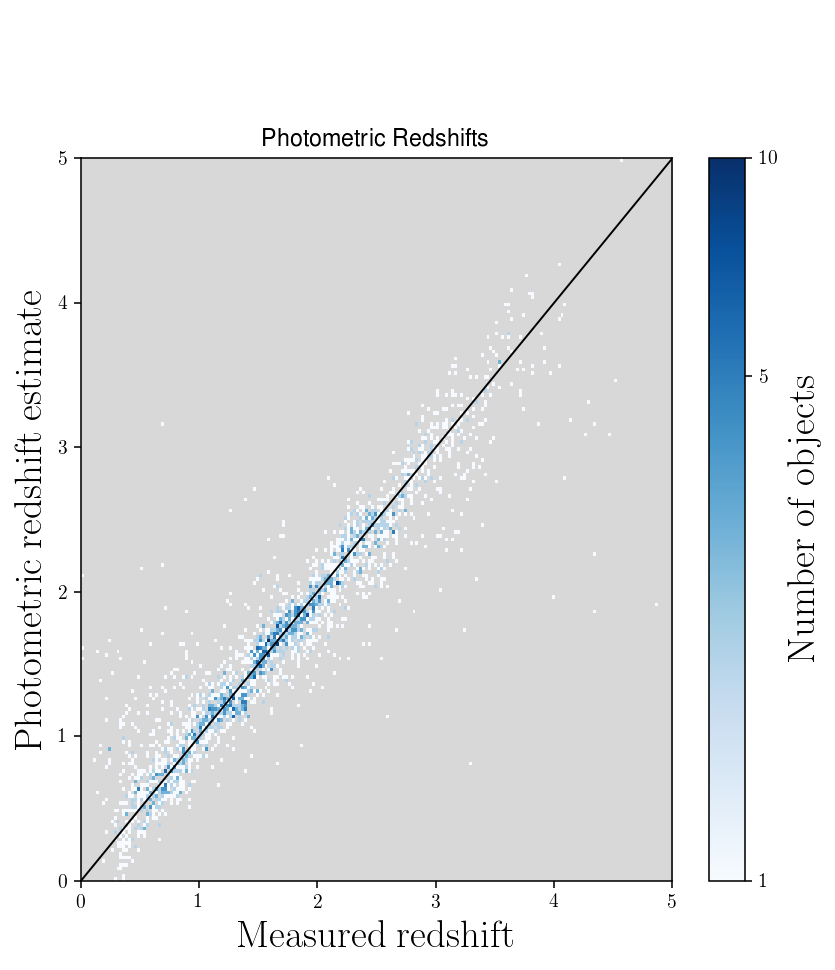

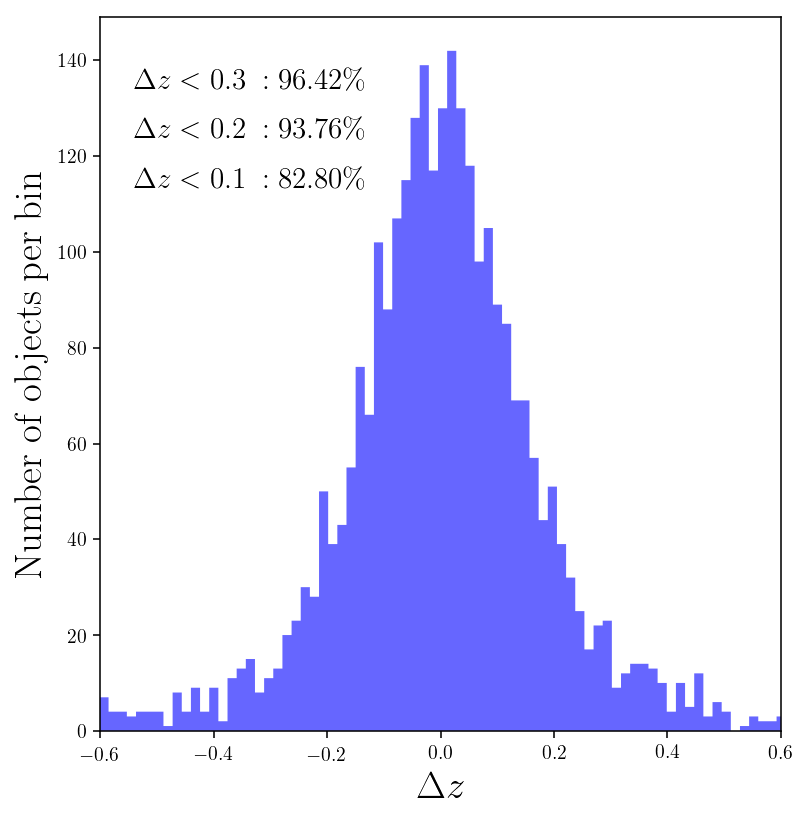

In [50]:
from class_photoz import photoz_analysis as pz_an

pz_an.plot_redshifts(y_test,y_pred)
pz_an.plot_error_hist(y_test,y_pred)

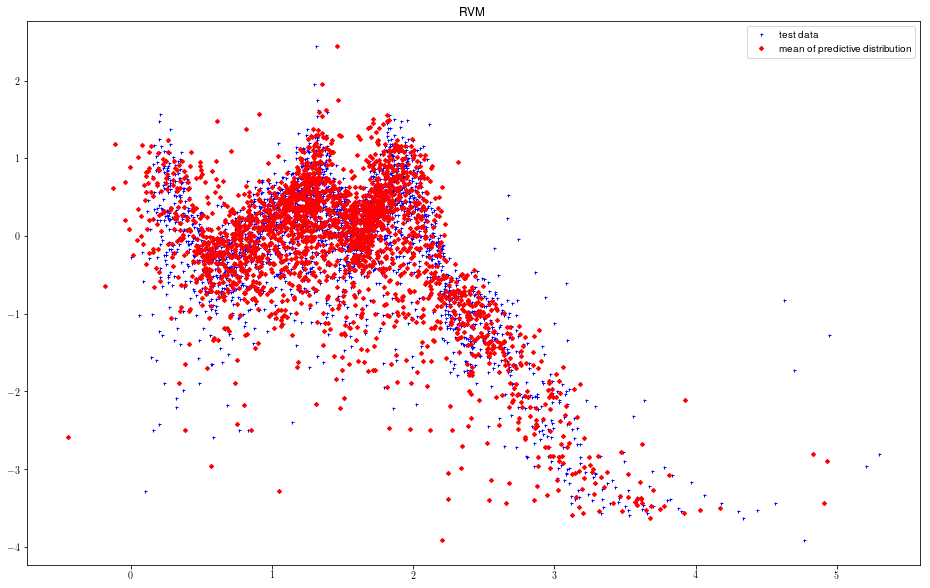

In [43]:
x = X_test
y = y_test
y_hat = y_pred
Y = y_train
i = 0
# plot test vs predicted data
plt.figure(figsize = (16,10))
plt.plot(y,x[:,i],"b+",markersize = 3, label = "test data")
plt.plot(y_hat,x[:,i],"rD", markersize = 3, label = "mean of predictive distribution")

# plot one standard deviation bounds
#plt.plot(x[:,i],y_hat + np.sqrt(var),"co", markersize = 3, label = "y_hat +- std")
#plt.plot(x[:,i],y_hat - np.sqrt(var),"co", markersize = 3)
#plt.plot(rvm.relevant_vectors_,Y[rvm.active_],"co",markersize = 12,  label = "relevant vectors")
plt.legend()
plt.title("RVM")
plt.show()